<a href="https://colab.research.google.com/github/yourfutureself/CSCI409901/blob/main/GPU_BBB_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as funct
import torch.optim as optim
#import pickle
import torch
import torchvision


from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
#from torchsummary import summary
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL.Image import fromarray


from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajkumarl/people-clothing-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/people-clothing-segmentation


In [ ]:
import shutil
import os

# Source and destination paths
source_path = path # '/kaggle/input/people-clothing-segmentation'
destination_path = '/content/people-clothing-segmentation'

# Create the destination directory if it doesn't exist
#os.makedirs(destination_path, exist_ok=True) # Removed this line to prevent re-creation

# Copy the dataset (instead of moving)
for item in os.listdir(source_path):
    s = os.path.join(source_path, item)
    d = os.path.join(destination_path, item)
    if os.path.isdir(s):
        # Use distutils.dir_util.copy_tree for merging existing directories
        # !pip install distutils
        from distutils.dir_util import copy_tree
        copy_tree(s, d, update=1)  # update=1 to update existing files
                                      # and directories
    else:
        shutil.copy2(s, d)
        print("used copy2")

print(f"Dataset copied from '{source_path}' to '{destination_path}'")

used copy2
used copy2
Dataset copied from '/kaggle/input/people-clothing-segmentation' to '/content/people-clothing-segmentation'


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cpu


In [ ]:
df = pd.read_csv('/content/people-clothing-segmentation/labels.csv')

class_map = {}
for index, row in df.iterrows():
    grayscale_value = row['Unnamed: 0']  # Assuming the column name is 'grayscale_value'
    class_name = row['label_list']  # Assuming the column name is 'class_name'
    class_map[grayscale_value] = class_name
print(class_map)

{0: nan, 1: 'accessories', 2: 'bag', 3: 'belt', 4: 'blazer', 5: 'blouse', 6: 'bodysuit', 7: 'boots', 8: 'bra', 9: 'bracelet', 10: 'cape', 11: 'cardigan', 12: 'clogs', 13: 'coat', 14: 'dress', 15: 'earrings', 16: 'flats', 17: 'glasses', 18: 'gloves', 19: 'hair', 20: 'hat', 21: 'heels', 22: 'hoodie', 23: 'intimate', 24: 'jacket', 25: 'jeans', 26: 'jumper', 27: 'leggings', 28: 'loafers', 29: 'necklace', 30: 'panties', 31: 'pants', 32: 'pumps', 33: 'purse', 34: 'ring', 35: 'romper', 36: 'sandals', 37: 'scarf', 38: 'shirt', 39: 'shoes', 40: 'shorts', 41: 'skin', 42: 'skirt', 43: 'sneakers', 44: 'socks', 45: 'stockings', 46: 'suit', 47: 'sunglasses', 48: 'sweater', 49: 'sweatshirt', 50: 'swimwear', 51: 't-shirt', 52: 'tie', 53: 'tights', 54: 'top', 55: 'vest', 56: 'wallet', 57: 'watch', 58: 'wedges'}


#params


In [ ]:
class Params:
  seed: int = 161
  img_dim_x: int = 550
  img_dim_y: int = 825
  image_dir = os.path.join(destination_path, 'png_images', 'IMAGES')  # Use updated paths
  mask_dir = os.path.join(destination_path, 'png_masks', 'MASKS')
  mask_files = os.listdir(mask_dir)
  image_files = os.listdir(image_dir)

  album_bbox_form: str = "pascal_voc"
  batch_size = int = 16
  custom_model = int = 1
  learning_rate = float = 0.005
  class_map = class_map
  class_num = len(class_map)
  num_workers: int = 7
  num_epochs: int = 3


In [ ]:
import shutil
os.makedirs('/content/people-clothing-segmentation/png_images/VAL_IMAGES/', exist_ok=True)
os.makedirs('/content/people-clothing-segmentation/png_masks/VAL_MASKS/', exist_ok=True)
os.makedirs('/content/people-clothing-segmentation/png_images/TEST_IMAGES/', exist_ok=True)
os.makedirs('/content/people-clothing-segmentation/png_masks/TEST_MASKS/', exist_ok=True)

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    Params.image_files, Params.mask_files, test_size=0.1, random_state=Params.seed  # Use your seed value
)

# Move validation files to validation folders
for file_name in val_image_files:
  image_number = file_name.split('_')[1].split('.')[0]  # Get 'xxxx' from 'img_xxxx.png'

    # Construct the corresponding mask file name
  mask_file_name = f"seg_{image_number}.png"

  mask_source_path = os.path.join(Params.mask_dir, mask_file_name)
  if os.path.exists(mask_source_path):
      shutil.move(os.path.join(Params.image_dir, file_name),
                  os.path.join('/content/people-clothing-segmentation/png_images/VAL_IMAGES/', file_name))
      shutil.move(mask_source_path,
                  os.path.join('/content/people-clothing-segmentation/png_masks/VAL_MASKS/', mask_file_name))
  else:
      print(f"Warning: Mask file not found: {mask_source_path}")

val_image_files = os.listdir('/content/people-clothing-segmentation/png_images/VAL_IMAGES/')
val_mask_files = os.listdir('/content/people-clothing-segmentation/png_masks/VAL_MASKS/')
test_image_files = os.listdir('/content/people-clothing-segmentation/png_images/TEST_IMAGES/')
test_mask_files = os.listdir('/content/people-clothing-segmentation/png_masks/TEST_MASKS/')

val_image_files, test_image_files, val_mask_files, test_mask_files = train_test_split(
      val_image_files, val_mask_files, test_size=0.5, random_state=Params.seed
  )
for file_name in test_image_files:
  image_number = file_name.split('_')[1].split('.')[0]  # Get 'xxxx' from 'img_xxxx.png'

    # Construct the corresponding mask file name
  mask_file_name = f"seg_{image_number}.png"

  if os.path.exists(mask_source_path):
      shutil.move(os.path.join('/content/people-clothing-segmentation/png_images/VAL_IMAGES/', file_name),
                  os.path.join('/content/people-clothing-segmentation/png_images/TEST_IMAGES/', file_name))
      shutil.move(mask_source_path,
                  os.path.join('/content/people-clothing-segmentation/png_masks/MASKS/TEST_MASKS/', mask_file_name))
  else:
      print(f"Warning: Mask file not found: {mask_source_path}")

#transform


In [ ]:
transform_func = transforms.Compose([
    transforms.Resize((Params.img_dim_y, Params.img_dim_x)),
    transforms.ToTensor(),
    #not sure about this v
    #transforms.Lambda(lambda x: (x * 3).repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

In [ ]:
print(Params.class_num)

59


#Model

In [ ]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_global(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT', progress=True, num_classes=91
                                                               ) #makes new model?

    if Params.custom_model != -1:
      in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
      model.roi_heads.box_predictor = FastRCNNPredictor(in_features, Params.class_num)
      #model.roi_heads.score_thresh = 0.3

    trainable_layers = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Extract layer name (e.g., 'layer4', 'roi_heads')
            layer_name = name.split('.')[0]  # Or adjust based on your model's structure
            if layer_name not in trainable_layers:
                trainable_layers.append(layer_name)

    lr = 5e-3  # Initial learning rate
    lr_decay_factor = 0.75
    reset_lrBB = 1e-2
    reset_lrpred = 5e-3
    reset_lrCLS = 5e-3
    reset_lrhead = 5e-3
    enterBB = 0
    enterPred = 0
    enterCLS = 0
    enterhead = 0
    # for idx, (name, param) in enumerate(reversed(list(model.named_parameters()))):
    #     # Append layer parameters with decreasing learning rate
    #   if any(layer_name in name for layer_name in trainable_layers):

    #     if 'backbone' in name and enterBB != 1:
    #         lr = reset_lrBB
    #         enterBB = 1
    #     if 'pred' in name and enterPred != 1:
    #         lr = reset_lrpred
    #         enterPred = 1
    #     if 'cls' in name and enterCLS != 1:
    #         lr = reset_lrCLS
    #         enterCLS = 1
    #     if 'head' in name and enterhead != 1:
    #         lr = reset_lrhead
    #         enterhead = 1

    #     param.requires_grad = True
    #     param.lr = lr
    #     lr *= lr_decay_factor  # Apply decay for the next layer
    #     #print(f'{idx}: lr = {lr:.6f}, {name}')
    #   else:
    #         param.requires_grad = False  # Freeze other parameters


    # for name, param in model.backbone.named_parameters():
    #     # Check if the name starts with 'layer' followed by a number
    #     if name.startswith('layer') and name[5:].isdigit():
    #         layer_num = int(name[5:])  # Extract the layer number
    #         if layer_num < 5:  # Freeze layers 0, 1, 2, 3, 4
    #             param.requires_grad = False



    # Unfreeze later layers of the backbone and the head (RPN, box predictor, mask predictor)
    # for name, param in model.named_parameters():
    #     if 'backbone.layer' not in name or (
    #         'backbone.layer' in name and int(name.split('.')[2]) >= 5
    #     ):  # Unfreeze layers 3 and above in backbone
    #         param.requires_grad = True

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        Params.class_num
    )
    # for name, param in model.named_parameters():
    #     if 'roi_heads' in name or 'mask' in name:
    #         param.requires_grad = True
            #print(f"Parameter: {name}, requires_grad: {param.requires_grad}")
    #model.roi_heads.score_thresh = 0.6
    #model.roi_heads.mask_thresh = 0.6
    model.to(device)
    #checkpoint = torch.load('save_model.pth', map_location=device)

# Filter the checkpoint to keep only the relevant keys
    #filtered_checkpoint = {k: v for k, v in checkpoint.items() if k in model.state_dict()}

# Load the filtered state dictionary
    #model.load_state_dict(filtered_checkpoint, strict=False)  # Use strict=False to ignore missing keys

    # last_25_params = list(model.parameters())[-25:]
    # for param in last_25_params:
    #   if param.dim() >= 2:
    #     torch.nn.init.kaiming_uniform_(param, a=0, mode='fan_in', nonlinearity='relu')
    return model



In [ ]:
def masks_to_boxes_manual(masks):
        """Converts boolean tensor masks to bounding boxes.

        Args:
            masks (torch.Tensor): A boolean tensor of shape (N, H, W)
                where N is the number of masks, H is the height, and W is the width.

        Returns:
            torch.Tensor: A tensor of shape (N, 4) containing the bounding boxes
                in the format (x1, y1, x2, y2) where (x1, y1) is the top-left
                corner and (x2, y2) is the bottom-right corner.
        """

        boxes = []
        for mask in masks:
            # Find the indices where the mask is True
            rows, cols = torch.where(mask)

            # If the mask is empty, return an empty box
            if len(rows) == 0 or len(cols) == 0:
                boxes.append(torch.tensor([0, 0, 0, 0], dtype=torch.float32)) # Empty box
                continue

            # Calculate bounding box coordinates
            x1 = cols.min().item()
            y1 = rows.min().item()
            x2 = cols.max().item()
            y2 = rows.max().item()

            boxes.append(torch.tensor([x1, y1, x2, y2], dtype=torch.float32))

        return torch.stack(boxes)

#Dataset maker


In [ ]:
#dataset
#import scipy
from torchvision import transforms, ops
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
import re
pattern = r"^img_\d{4}\.png$"
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class ClothingAndMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=transform_func, class_map=None, batch_size=Params.batch_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        self.mask_files = os.listdir(mask_dir)
        self.class_map = class_map
        self.batch_size = batch_size
        self.reverse_class_map = {v: k for k, v in self.class_map.items()}

    def __len__(self):
        return len(self.image_files)
    import torch


    def __getitem__(self, idx):
        #print("in getitme")
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        if re.match(pattern, self.image_files[idx]):
          image_number = self.image_files[idx].split('_')[1].split('.')[0]
          mask_file_name = f"seg_{image_number}.png"

          mask_path = os.path.join(self.mask_dir, mask_file_name)
          if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Could not find mask file: {mask_path}")

          mask = Image.open(mask_path).convert('L')
        else:
          image_number = self.image_files[idx].split('.')[0]
          mask_file_name = f"{image_number}.png"
          if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Could not find mask file: {mask_path}")
          mask_path = os.path.join(self.mask_dir, mask_file_name)
          mask = Image.open(mask_path).convert('L')


        #mask = torch.from_numpy(np.array(mask))
        # instances are encoded as different colors
        #obj_ids = torch.unique(mask)



        resize_transform = transforms.Resize((Params.img_dim_y, Params.img_dim_x))
        mask = resize_transform(mask)


        # image = resize_transform(image)
        # print("Image shape:", image.size)
        # print("Mask shape:", mask.size)
        # plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # plt.imshow(image)
        # plt.title('Original Image')
        # plt.axis('off')
        # plt.subplot(1, 2, 2)
        # plt.imshow(mask, cmap='gray')  # Display mask in grayscale
        # plt.title('Original Mask')
        # plt.axis('off')
        # plt.show()

        mask = np.array(mask)
        image = self.transform(image)
        labels = []
        masks = []
        from skimage.morphology import remove_small_objects



        # Get unique object IDs from the grayscale mask
        for class_id in range(1, Params.class_num):  # Iterate over all class IDs
            class_mask = mask == class_id  # Create binary mask for current class

            if class_mask.sum() <= 1:  # Check for empty mask
              continue
            if class_mask.sum() > 1:
                # labeled_mask, things_num = ndimage.label(class_mask)
                # print("things", things_num)
                # for j in range(1, things_num + 1):
                #   labeled_mask_j = torch.tensor(labeled_mask == j, dtype=torch.bool)
                  labeled_mask_j = torch.tensor(class_mask, dtype=torch.bool)
                  if labeled_mask_j.dim() == 1:
                    labeled_mask_j = labeled_mask_j.unsqueeze(0)
                    #print("labeled_mask_j shape:", labeled_mask_j.shape)
                  if labeled_mask_j.dim() == 2:  # Check if it's 2D after unsqueeze
                        masks.append(labeled_mask_j)
                        labels.append(class_id)
                  else:
                        print(f"Skipping mask with unexpected dimensions: {labeled_mask_j.shape}")
        # if idx % 16 == 0:
        #   print(len(masks))
        if not masks:
            print(f"Warning: No masks found for image {self.image_files[idx]}. Returning empty tensors.")
            # Return empty tensors or handle the case appropriately
            # Example: Return image with empty targets
            empty_boxes = torch.empty((0, 4), dtype=torch.float32)
            empty_labels = torch.empty((0,), dtype=torch.int64)
            empty_masks = torch.empty((0, Params.img_dim_y, Params.img_dim_x), dtype=torch.uint8)  # Adjust dimensions if needed
            # ... create empty target dictionary ...
            target = {
                "boxes": empty_boxes,
                "labels": empty_labels,
                "masks": empty_masks,
                "image_id": torch.tensor(idx, dtype=torch.int64),
                "area": torch.zeros((0,), dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64)
            }
            return image, target



        # boxes_list = []  # Create a list to store individual boxes
        # for box in boxes:  # Iterate through the detected boxes
        #     boxes_list.append([box[0].item(), box[1].item(), box[2].item(), box[3].item()])  # Convert each coordinate to a Python scalar
        # boxes = boxes_list
        # if not boxes:  # Check if boxes is empty
        #   print(f"Warning: No boxes found for image {self.image_files[idx]}, returning None.")
        #   return None, None



        # if idx % 16 == 0:
        #    print("num boxes after", len(boxes))
        #    print("num areas after", len(area))

        filtered_masks = []
        filtered_labels = []
        #filtered_area = []
        #filtered_boxes = []
        # {0: nan, 1: 'accessories', 2: 'bag', 3: 'belt', 4: 'blazer', 5: 'blouse', 6: 'bodysuit', 7: 'boots', 8: 'bra', 9: 'bracelet', 10: 'cape', 11: 'cardigan', 12: 'clogs', 13: 'coat', 14: 'dress', 15: 'earrings', 16: 'flats', 17: 'glasses', 18: 'gloves', 19: 'hair', 20: 'hat', 21: 'heels', 22: 'hoodie', 23: 'intimate', 24: 'jacket', 25: 'jeans', 26: 'jumper', 27: 'leggings', 28: 'loafers', 29: 'necklace', 30: 'panties', 31: 'pants', 32: 'pumps', 33: 'purse', 34: 'ring', 35: 'romper', 36: 'sandals', 37: 'scarf', 38: 'shirt', 39: 'shoes', 40: 'shorts', 41: 'skin', 42: 'skirt', 43: 'sneakers', 44: 'socks', 45: 'stockings', 46: 'suit', 47: 'sunglasses', 48: 'sweater', 49: 'sweatshirt', 50: 'swimwear', 51: 't-shirt', 52: 'tie', 53: 'tights', 54: 'top', 55: 'vest', 56: 'wallet', 57: 'watch', 58: 'wedges'}


        for mask, label in zip(masks, labels):
            class_name = self.class_map.get(label)  # Get class name from label
            if class_name not in ['nan', 'watch', 'ring', 'earrings', 'necklace', 'accessories']:  # Check if class name is not "nan" or "skin"
                filtered_masks.append(mask)
                filtered_labels.append(label)
                #filtered_area.append(area)
                #filtered_boxes.append(boxes)

        # Update masks and labels with filtered values
        masks = filtered_masks
        labels = filtered_labels
        #area = filtered_area
        #boxes = filtered_boxes
        if not masks:
          print(f"Warning: No masks found for image {self.image_files[idx]}, returning None.")
          return None, None
        # masks = masks[1:]
        # labels = labels[1:]
        # area = area[1:]
        # boxes = boxes[1:]
        #add this check:
        if len(labels) != len(masks):
          print(f"label filter Warning: Inconsistent lengths for image {self.image_files[idx]}:"
              f" boxes: {len(boxes)}, labels: {len(labels)}, masks: {len(masks)}")
        image_id = idx

        masks = torch.stack(masks)
            # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # Calculate area
        area_threshold = 10
        # if idx % 7 == 0:
        #   print("num boxes", len(boxes))
        #   print("num areas", len(area))
        valid_boxes_indices = area > area_threshold
        if not valid_boxes_indices.any():
            print(f"Warning: No valid boxes found for image {self.image_files[idx]}, returning None.")
            return None, None
        if len(boxes) != len(labels) or len(boxes) != len(masks):
          print(f"box filter Warning: Inconsistent lengths for image {self.image_files[idx]}:"
              f" boxes: {len(boxes)}, labels: {len(labels)}, masks: {len(masks)}")

        boxes = boxes[valid_boxes_indices]
        labels = [label for i, label in enumerate(labels) if valid_boxes_indices[i]]  # Filter labels
        masks = masks[valid_boxes_indices]  # Filter masks
        area = area[valid_boxes_indices]

        # masks = [torch.from_numpy(mask) for mask in masks]
        # masks = torch.stack(masks)  # Stack individual masks along a new dimension
        # masks = masks.type(torch.bool)  # Convert to Boolean type
        #boxes = torch.as_tensor(boxes, dtype=torch.float32)  # Ensure boxes are tensors
        labels = torch.tensor(labels, dtype=torch.int64).to(device)
        iscrowd = torch.zeros(((Params.class_num+1),), dtype=torch.int64).to(device)
        image_id = torch.tensor(idx, dtype=torch.int64).to(device)  # or torch.tensor([idx], dtype=torch.int64) for a single-element tensor
        area = torch.as_tensor(area, dtype=torch.float32).to(device)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64).to(device)

        # boxes_list = []  # Create a list to store individual boxes
        # for box in boxes:  # Iterate through the detected boxes
        #     boxes_list.append([box[0].item(), box[1].item(), box[2].item(), box[3].item()])
        # boxes = boxes_list
        #boxes = boxes.to(device).type(torch.float32) # Ensure boxes are float32
        boxes.requires_grad = True  # Enable gradient calculation for boxes

        #labels = torch.tensor(labels, dtype=torch.int64).to(device)
        # labels.requires_grad = True # Labels are typically not differentiable

        masks = masks.type(torch.float32).to(device) # Ensure masks are float32
        masks.requires_grad = True  # Enable gradient calculation for masks

        #area = torch.as_tensor(area, dtype=torch.float32).to(device)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image)).to(device)
        target["masks"] = masks.to(device)
        target["labels"] = labels.to(device)
        #print(labels)
        target["image_id"] = image_id.to(device)
        target["area"] = area.to(device)
        #print(area)
        target["iscrowd"] = iscrowd.to(device)
        # print("Image shape:", image.shape, "dtype:", image.dtype)
        # print("Bounding boxes:", target['boxes'])
        # print("Labels:", target['labels'])
        # print("Masks shape:", target['masks'].shape, "dtype:", target['masks'].dtype)




        # for targ in target:
        #   for k, v in targ.items():
        #     if isinstance(v, torch.Tensor) and (torch.isnan(v).any() or torch.isinf(v).any()):
        #         print(f"WARNING: Encountered NaN/Inf in target key '{k}'! Stopping training.")
        #         return None, None
        # if idx % 32 == 0:

        #     import matplotlib.gridspec as gridspec


        #     # Set up the figure with flexible layout
        #     num_masks = target['masks'].shape[0]
        #     fig = plt.figure(figsize=(4 * num_masks, 6))
        #     gs = gridspec.GridSpec(2, num_masks, height_ratios=[1, 2])  # 2 rows: image + masks

        #     # --- Top Row: The Processed Image ---
        #     ax_image = plt.subplot(gs[0, :])  # Image takes entire top row
        #     ax_image.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)
        #     ax_image.set_title('Processed Image')
        #     ax_image.axis('off')

        #     # --- Bottom Row: All Masks ---
        #     for i in range(num_masks):
        #         ax = plt.subplot(gs[1, i])
        #         mask_to_display = target['masks'][i].squeeze().type(torch.float32).cpu().numpy()
        #         ax.imshow(mask_to_display, cmap='gray')
        #         label_index = target['labels'][i].item()
        #         text_label = self.class_map.get(label_index, f"Unknown Label {label_index}")
        #         ax.set_title(text_label)
        #         ax.axis('off')

        #     plt.tight_layout()
        #     plt.show()

        return image, target





#DataModule (lightning)


In [ ]:
%%capture
!pip install pytorch-lightning
!pip install pytorch-lightning-bolts
import pytorch_lightning as pl
class Mask_DM(pl.LightningDataModule):
  def __init__(
        self,
        rand_seed= Params.seed,
        img_dim_x= Params.img_dim_x,
        img_dim_y= Params.img_dim_y,
        class_num= Params.class_num,
        class_map= Params.class_map,
        batch_size= Params.batch_size,
        num_workers= Params.num_workers,
        transform_func= transform_func,
        learning_rate= Params.learning_rate,
        num_epochs= Params.num_epochs

  ):
        super().__init__()
        self.rand_seed = rand_seed
        self.img_dim_x = img_dim_x
        self.img_dim_y = img_dim_y
        self.class_num = class_num
        self.class_map = class_map
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform_func
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

  def setup(self, stage=None):
        self.train = ClothingAndMaskDataset(
            Params.image_dir,
            Params.mask_dir,
            transform=self.transform,
            class_map=self.class_map,
              batch_size=self.batch_size)
        self.val = ClothingAndMaskDataset(
            os.path.join(destination_path, 'png_images/VAL_IMAGES/'),
            os.path.join(destination_path, 'png_masks/VAL_MASKS/'),
            transform=self.transform,
              class_map=self.class_map,
            batch_size=self.batch_size
        )
        self.test = ClothingAndMaskDataset(
            os.path.join(destination_path, 'png_images/TEST_IMAGES/'),
            os.path.join(destination_path, 'png_masks/TEST_MASKS/'),
            transform=self.transform,
              class_map=self.class_map,
            batch_size=self.batch_size
        )
  def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.custom_collate
        )
  def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.custom_collate  # If needed
        )
  def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.custom_collate  # If needed
        )


  def custom_collate(self, batch):
    #print("in custom collate")
    imgs = []
    targets = []

    valid_batch = [(img, targ) for img, targ in batch if img is not None and targ is not None]

    if not valid_batch:  # If all samples in the batch are invalid, return empty tensors
        print("Warning: All samples in the batch are invalid. Returning empty tensors.")
        return None, None  # Return None for both images and targets

    for image, target in batch:
            if image is None or target is None:
                print("Warning: Skipping invalid sample in batch.")  # Add for debugging
                continue  # Skip this sample

            imgs.append(image)
            targets.append(target)
    if not imgs or not targets:  # Check if the batch is empty
            print("Warning: Batch is empty. Returning None.")
            return None, None  # Return None to skip this batch


    imgs = torch.stack(imgs)

    return imgs, targets  # Return only the valid data





In [ ]:
def visualize_predictions(self, image, predictions, targets):
        # Draw bounding boxes
        labels = [str(label.item()) for label in predictions['labels']]
        image_with_boxes = draw_bounding_boxes(
            image, predictions['boxes'], labels=labels, width=3 # Pass the converted labels
        )

        # Draw segmentation masks
        # ... (get target masks or predictions masks depending on what you want to visualize) ...
        target_masks = targets['masks']
        image_with_masks = draw_segmentation_masks(image, target_masks, alpha=0.5)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_with_boxes.permute(1, 2, 0))
        plt.title('Bounding Boxes')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image_with_masks.permute(1, 2, 0))
        plt.title('Segmentation Masks')
        plt.axis('off')
        plt.show()

In [ ]:
def save_model(model, path):
    """Saves the model to a file using PyTorch's save function.

    Args:
        model: The PyTorch model to save.
        path (str): The path where the model will be saved.
    """
    torch.save(model.state_dict(), path)

In [ ]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import box_iou
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
class Mask_LM(pl.LightningModule):
  def __init__(
        self,
        rand_seed= Params.seed,
        img_dim_x= Params.img_dim_x,
        img_dim_y= Params.img_dim_y,
        num_classes = Params.class_num,
        album_bbox_form= Params.album_bbox_form,
        class_map= Params.class_map,
        batch_size= Params.batch_size,
        num_workers= Params.num_workers,
        transform_func= transform_func,
        learning_rate= Params.learning_rate,
        num_epochs= Params.num_epochs

  ):
        super().__init__()
        self.rand_seed = rand_seed
        self.img_dim_x = img_dim_x
        self.img_dim_y = img_dim_y
        self.num_classes = num_classes
        self.album_bbox_form = album_bbox_form
        self.class_map = class_map
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform_func
        self.model = self.get_model(num_classes).to(device)
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.optimizers= self.configure_optimizers()
        self.optimizer = self.optimizers["optimizer"]
        self.automatic_optimization = False


  def check_box_predictions(self, images, targets, predictions):
      # 1. Check if predictions and targets have boxes and masks
      if "boxes" not in predictions[0]:
            print("Warning: Missing 'boxes' in predictions.")
            return False #Changed from True to False
      if "masks" not in targets[0]:
          print("Warning: Missing 'masks' in targets.")
          return False #Changed from True to False

      # 2. Iterate through the batch
      for i in range(len(images)):
          target_masks = targets[i]["masks"]
          predicted_boxes = predictions[i]["boxes"]
          #print("target_masks", target_masks.shape)
          print("predicted_boxes", predictions[0][i]['boxes'].shape[0])

          # 3. Check if there are masks but no boxes
          if target_masks.shape[0] > 0 and predicted_boxes.shape[0] == 0:
              print(f"Warning: Masks present but no boxes predicted for image {i}.")
              return False  # Or you might want to continue and check other images

          # 4. (Optional) Check if box coordinates are within image boundaries
          image_height, image_width = images[i].shape[-2:]
          for box in predicted_boxes:
              x1, y1, x2, y2 = box
              if not (0 <= x1 <= image_width and 0 <= y1 <= image_height and
                      0 <= x2 <= image_width and 0 <= y2 <= image_height):
                  print(f"Warning: Box coordinates out of bounds for image {i}.")
                  return False  # Or continue to check other boxes

      # 5. If all checks pass, consider box predictions reasonable
      return True


  def calculate_iou_without_background(self, predicted_masks, target_masks, num_classes):
    """Calculates IoU for each class, excluding the background class (assumed to be class 0)."""

    iou_per_class = []
    for class_id in range(1, num_classes):  # Iterate over classes, excluding background (class 0)
        # Create binary masks for the current class
        predicted_class_mask = predicted_masks == class_id
        target_class_mask = target_masks == class_id

        # Calculate intersection and union
        intersection = (predicted_class_mask & target_class_mask).sum().item()
        union = (predicted_class_mask | target_class_mask).sum().item()

        # Calculate IoU (handle division by zero)
        iou = intersection / union if union else 1.0  # If union is 0, IoU is 1 (perfect match)
        iou_per_class.append(iou)

    return torch.tensor(iou_per_class)  # Return IoU values for each class
  def forward(self, images, targets=None):
    # 1. Forward pass
    print("Entering forward function")
    # If targets are provided, move them to the device before forward pass
    if targets is not None:
        targets = [{k: v.to(self.device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()}
                   for t in targets]

    try:
        output = self.model(images, targets)
        # if self.check_box_predictions(images, targets, output):
        #     print("Box predictions seem reasonable.")
        #     if not isinstance(output, list):
        #         output = [output]  # Wrap in a list
        #     print("Forward function completed", output)
        #     return output
        # else:
        #     print("Box predictions do not seem reasonable.")
        #     if not isinstance(output, list):
        #         output = [output]  # Wrap in a list
        #     print("Forward function completed", output)
        #     return output
    except Exception as e:
        print(f"Exception during forward pass: {e}")
        #print("Images shape:", images.shape, images.dtype, images.device)
        if targets is not None:
            for i, t in enumerate(targets):
                for k, v in t.items():
                    if isinstance(v, torch.Tensor):
                        #print(f"Target {i} - {k}: shape={v.shape}, dtype={v.dtype}, device={v.device}")
                        if torch.isnan(v).any() or torch.isinf(v).any():
                            print(f"WARNING: NaN/Inf found in target {i} - {k}")
        return None  # Or handle the exception in another way

    # Wrap in a list if it's not already a list
    if not isinstance(output, list):
        output = [output]  # Wrap in a list
    print("Forward function completed", output)
    return output
  def get_model(self, num_classes):
    #print("Getting Model")
    return get_model_global(num_classes)

  def training_step(self, batch, batch_idx):
    #print("Training Step")
    images, targets = batch
    if images is None or targets is None:
        print("Skipping batch due to empty tensors.")  # Add for debugging
        return None
    images = images.to(device)

    # # for overfiting :
    # targets_copy = [{k: v.clone().detach().to(device) if isinstance(v, torch.Tensor) else v
    #                  for k, v in t.items()}
    #                 for t in targets]

    # # Now use targets_copy instead of targets
    # self.model.train()
    # loss_dict = self(images, targets_copy) # Pass the copy to the model


    #normal :
    for target in targets:  # Loop through each target in the batch
        for key, value in target.items():
            if isinstance(value, torch.Tensor):
                # if key != 'boxes':
                #     # Check for floating-point type and set requires_grad
                #     if value.dtype in [torch.float32, torch.float64, torch.float16]:
                #         value.requires_grad = True
                target[key] = value.to(device)
    self.model.train()
    #print("before forward")
    loss_dict = self(images, targets)
    #print(loss_dict)
    # Check if loss_dict is None before proceeding
    if loss_dict is None:
        print("Skipping batch due to None loss_dict.")
        return None  # or handle appropriately, e.g., log the event


    self.optimizer.zero_grad()
    # try ignoring mask loss:
    # loss_dict = self(images, targets) # Get the loss dictionary
    # del loss_dict[0]['loss_mask']

    # for name, param in self.model.named_parameters():
    #   print(name, param.requires_grad)

    # l1_lambda = 0.001  # Adjust the regularization strength
    # l1_reg = torch.tensor(0., device=device)  # Initialize the regularization term
    # for name, param in self.model.named_parameters():
    #   if 'backbone' in name and 'weight' in name:  # Apply to backbone weights
    #     l1_reg += torch.norm(param, 1)  # Calculate L1 norm of weights

    #    # Add L1 regularization to the total loss
    # total_loss = sum(loss for loss in loss_dict[0].values()) + l1_lambda * l1_reg

    weight_classifier = 1.0
    weight_box_reg = 2.0  # Increased weight for box regression
    weight_mask = 3.0      # Increased weight for mask segmentation
    weight_objectness = 0.5
    weight_rpn_box_reg = 1.0

    loss_classifier = loss_dict[0]['loss_classifier']
    loss_box_reg = loss_dict[0]['loss_box_reg']
    loss_mask = loss_dict[0]['loss_mask']
    loss_objectness = loss_dict[0]['loss_objectness']
    loss_rpn_box_reg = loss_dict[0]['loss_rpn_box_reg']

    total_loss = (
      weight_classifier * loss_classifier +
      weight_box_reg * loss_box_reg +
      weight_mask * loss_mask +
      weight_objectness * loss_objectness +
      weight_rpn_box_reg * loss_rpn_box_reg
    )
    self.log('train_loss', total_loss)  # Log the total loss
    # total_loss = sum(loss for loss in loss_dict[0].values()) # Get all loss values from the dictionary and sum them
    if torch.isnan(total_loss) or torch.isinf(total_loss):
      print("WARNING: Encountered NaN/Inf in loss! Stopping training.")
# You might want to log this event or save the model state for debugging
      self.trainer.should_stop = True  # Stop training
      return None

    # predictions = {
    #     "masks": loss_dict[0]['loss_mask']  # Assuming the predictions are stored under 'masks' key
    # }
    # iou_without_bg = self.calculate_iou_without_background(
    #     predictions[0]['masks'].argmax(dim=0),  # Get predicted masks (assuming multi-class output)
    #     targets[0]['masks'].squeeze(1),  # Get target masks
    #     self.num_classes
    # )
    # reward_weight = 3.0  # Adjust this weight to control the reward's influence
    # reward_term = torch.exp(reward_weight * iou_without_bg).mean()  # Exponential reward based on IoU

    # # 3. Adjust the total loss
    # total_loss = total_loss - reward_term  # Subtract the reward from the loss (to maximize reward)

    #self.log('train_loss', total_loss)  # Log the total loss
    # total_loss = total_loss.item() if isinstance(total_loss, torch.Tensor) else total_loss
    # total_loss = torch.tensor(total_loss, device=device).to(device)
    #print("total loss", total_loss)


    total_loss.backward()

    # last_20_params = list(reversed(list(self.model.named_parameters())))[-20:]

    # print("Gradients of the last 20 parameters:")
    # for name, param in last_20_params:
    #     if param.grad is not None:  # Check if gradient exists
    #         print(f"{name}: {param.grad}")  # Print gradient
    #         if param.requires_grad == True: print("requires grad")
    #         #print(f"{name}: {param.requires_grad == True}")
    #     else:
    #         print(f"{name}: No gradient")
    # roi_pred_mask_params = [
    #     param for name, param in self.model.named_parameters()
    #     if 'roi_heads.box_predictor' in name or 'roi_heads.mask_predictor' in name
    # ]
    # last_20_params = roi_pred_mask_params[-20:]

    # print("Gradients of the last 20 parameters (including ROI prediction and mask layers):")
    # for i, param in enumerate(last_20_params):  # Iterate through parameters with index
    #     if param.grad is not None:  # Check if gradient exists
    #         print(f"Parameter {i}: {param.grad}")  # Print gradient
    #         #print("requires grad:")
    #         #print(f"{name}: {param.requires_grad == True}")
    #     else:
    #         print(f"Parameter {i}: No gradient")
    if (batch_idx % 5) == 0:
      print(f"Batch {batch_idx} Loss: {total_loss.item()}")
      #print("loss dict:", loss_dict)
      #print("weights", l1_reg)

      # with torch.no_grad():
      #       self.model.eval()
      #       predictions = self.model(images)
      #       accuracy = self.calculate_accuracy(predictions, targets)
      #       precision = self.calculate_precision(predictions, targets)

      #   # Log the metrics
      #       self.log('val_accuracy', accuracy)
      #       self.log('val_precision', precision)
      #       # Loop through the predictions and targets to visualize them

      #       #visualize_predictions(images[1], predictions[1], targets[1])
      #       self.model.train()


    for param in self.model.parameters():
      if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
          print("WARNING: Encountered NaN/Inf in gradients! Stopping training.")
          self.trainer.should_stop = True
          return None
    # initial_params = []
    # for name, param in reversed(list(self.model.named_parameters())):
    #     if len(initial_params) < 20:  # Limit to the first 20 parameters
    #         initial_params.append((name, param.clone().detach()))

    #adjust lr:
    # grad_norm = 0
    # for param in self.model.parameters():
    #     if param.grad is not None:
    #         grad_norm += param.grad.data.norm(2).item()  # Calculate L2 norm
    # grad_norm /= len(list(filter(lambda p: p.grad is not None, self.model.parameters())))

    # # Define a threshold for gradient norm
    # grad_norm_threshold = 1.0  # Adjust this value as needed

    # # Reduce learning rate if gradient norm is below the threshold
    # if grad_norm < grad_norm_threshold:
    #     for param_group in self.optimizer.param_groups:
    #         param_group['lr'] *= 0.9



    self.optimizer.step()  # Perform the optimizer step

    # After optimizer step: Calculate and print the change in weights and biases
    # print("Change in weights and biases:")
    # for i, (name, initial_param) in enumerate(initial_params):
    #     current_param = dict(self.model.named_parameters())[name]
    #     change = current_param - initial_param
    #     print(f"{i}. {name}: {change.abs().mean().item()}")  # Print the average absolute change # Print the average change

    save_model(m_lm.model, '/content/save_model.pth')
    return total_loss
  def test_step(self, batch, batch_idx):
        images, targets = batch
        images = images.to(device)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Handle cases where the batch might be None (due to filtering in the dataset)
        if images is None or targets is None:
          print("Skipping batch in test_step due to invalid data.")
          return {}

    # Set model to evaluation mode
        self.model.eval()

        with torch.no_grad():

            predictions = self.model(images)

            # 4. Calculate evaluation metrics (if needed)
            accuracy = self.calculate_accuracy(predictions, targets)
            print(f"Batch Accuracy (test_step): {accuracy:.4f}")  # Debugging print
            return {"test_accuracy": accuracy}


  def validation_step(self, batch, batch_idx):
        save_model(m_lm.model, '/content/save_model.pth')
        images, targets = batch
        images = images.to(device)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if images is None or targets is None:
            print("Skipping batch in validation_step due to invalid data.")  # Optional: Add for debugging
            return {}
        # 1. Set model to evaluation mode
        self.model.eval()
        score_threshold = 0.1
        # 2. Forward pass
        assert not self.model.training, "Model is not in evaluation mode!"
        plt.rcParams["savefig.bbox"] = 'tight'
        def show(imgs):
            if not isinstance(imgs, list):
                imgs = [imgs]
            fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
            for i, img in enumerate(imgs):
                img = img.detach()
                img = F.to_pil_image(img)
                axs[0, i].imshow(np.asarray(img))
                axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        with torch.no_grad():
          predictions = self.model(images)
            #print("Predictions:", predictions)

          #accuracy = self.calculate_accuracy(predictions, targets)

            # 5. Log the metric
          #self.log('val_accuracy', accuracy)
          #image = images[1]
          #prediction = predictions[1]
          #filtered_boxes = prediction['boxes'][prediction['scores'] > score_threshold]
          # Now use the filtered boxes to create the overlay
          #overlay = draw_bounding_boxes(image, filtered_boxes, width=5)
          # Define the show function within the same cell:

          #show(overlay)
        return predictions
  # Add this to verify your data before training
  # def on_train_start(self):
  #     # Check a sample batch
  #     sample = next(iter(self.train_dataloader()))
  #     images, targets = sample
  #     print(f"Batch shape: {images.shape}")
  #     print(f"Number of targets: {len(targets)}")
  #     print(f"Sample target keys: {targets[0].keys()}")

  #     # Verify model structure
  #     print("Model structure:")
  #     print(self.model)

  #     # Check which layers are trainable
  #     print("\nTrainable parameters:")
  #     for name, param in self.model.named_parameters():
  #         if param.requires_grad:
  #             print(name)
  def configure_optimizers(self):
    # 1. Define the optimizer
    params = [p for p in self.model.parameters() if p.requires_grad]
    #print("params from optimizer", params)
    optimizer = torch.optim.SGD(params, lr=self.learning_rate, momentum=0.9)

    # 2. Define the scheduler
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    # 3. Return optimizer and scheduler
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "interval": "epoch",  # Adjust frequency: "epoch" or "step"
            "frequency": 1  # How often to apply the scheduler
        }
    }
  def calculate_accuracy(self, predictions, targets):
    """Calculates accuracy based on IoU threshold."""
    iou_threshold = 0.5  # Set your desired IoU threshold
    correct_predictions = 0
    total_predictions = 0

    for prediction, target in zip(predictions, targets):
        predicted_boxes = prediction['boxes']
        predicted_labels = prediction['labels']
        target_boxes = target['boxes']
        target_labels = target['labels']

        # Check if predicted_boxes is empty
        if predicted_boxes.shape[0] == 0:
            # If empty, skip this prediction and continue to the next one
            # You might want to log this event or handle it differently
            print("Warning: No predicted boxes found for this image. Skipping accuracy calculation.")
            continue

        # Calculate IoU between predicted and target boxes
        iou_matrix = torchvision.ops.box_iou(predicted_boxes, target_boxes)

        # Find the best matching target box for each predicted box
        matched_indices = iou_matrix.argmax(dim=1)

        # Count correct predictions based on IoU and label match
        for i, predicted_label in enumerate(predicted_labels):
            if iou_matrix[i, matched_indices[i]] >= iou_threshold and predicted_label == target_labels[matched_indices[i]]:
                correct_predictions += 1

        total_predictions += len(predicted_boxes)

    accuracy = correct_predictions / total_predictions if total_predictions else 0
    return accuracy

  def calculate_precision(self, predictions, targets):
    """Calculates precision based on IoU threshold."""
    iou_threshold = 0.5  # Set your desired IoU threshold
    true_positives = 0
    false_positives = 0

    for prediction, target in zip(predictions, targets):
        predicted_boxes = prediction['boxes']
        predicted_labels = prediction['labels']
        target_boxes = target['boxes']
        target_labels = target['labels']

        # Calculate IoU between predicted and target boxes
        iou_matrix = torchvision.ops.box_iou(predicted_boxes, target_boxes)

        # Find the best matching target box for each predicted box
        matched_indices = iou_matrix.argmax(dim=1)

        # Count true positives and false positives based on IoU and label match
        for i, predicted_label in enumerate(predicted_labels):
            if iou_matrix[i, matched_indices[i]] >= iou_threshold and predicted_label == target_labels[matched_indices[i]]:
                true_positives += 1
            else:
                false_positives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0
    return precision


In [ ]:

del m_dm, m_lm



NameError: name 'm_dm' is not defined

In [ ]:
m_dm = Mask_DM()
m_dm.learning_rate = Params.learning_rate
m_dm.class_map = Params.class_map
m_dm.class_num = Params.class_num
m_dm.setup()
m_lm = Mask_LM()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 150MB/s]


In [ ]:
import gc
gc.collect()
#torch.cuda.empty_cache()

38

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable frozen module validation
os.environ['PYDEVD_DISABLE_ROOT_VALIDATION'] = '1'  # Disable root module validation


In [ ]:
if torch.cuda.is_available():
    accelerator = 'cuda'
    strategy = 'ddp_notebook' # or 'ddp_spawn' depending on your needs
elif torch.backends.mps.is_available():
    accelerator = 'mps'
    strategy = 'ddp_spawn' # or 'ddp_spawn' depending on your needs
else:
    accelerator = 'cpu'
    strategy = 'auto'

In [ ]:
print("Accelerator:", accelerator)
print("Strategy:", strategy)

Accelerator: cpu
Strategy: auto


In [ ]:
 # No strategy needed for CPU training
# accelerator = 'cuda'
# strategy = 'ddp_notebook'
trainer = pl.Trainer(accelerator=accelerator, max_epochs=Params.num_epochs,
                    num_sanity_val_steps=0, strategy=strategy)

if __name__ == '__main__':
  trainer.fit(m_lm, train_dataloaders=m_dm.train_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | MaskRCNN | 44.2 M | train
-------------------------------------------
44.0 M    Trainable params
222 K     Non-trainable params
44.2 M    Total params
176.917   Total estimated model params size (MB)
207       Modules in train mode
0      

Training: |          | 0/? [00:00<?, ?it/s]

Entering forward function
Forward function completed [{'loss_classifier': tensor(3.3770, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4369, grad_fn=<DivBackward0>), 'loss_mask': tensor(0.8186, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.3052, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0448, grad_fn=<DivBackward0>)}]
Batch 0 Loss: 6.904044151306152
Entering forward function
Forward function completed [{'loss_classifier': tensor(1.4067, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3772, grad_fn=<DivBackward0>), 'loss_mask': tensor(0.7768, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.2142, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0465, grad_fn=<DivBackward0>)}]
Entering forward function
Forward function completed [{'loss_classifier': tensor(1.1578, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4656, grad_fn=<DivBackward0>), 

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

/usr/local/lib/python3.11/dist-packages/torchvision/utils.py:215: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


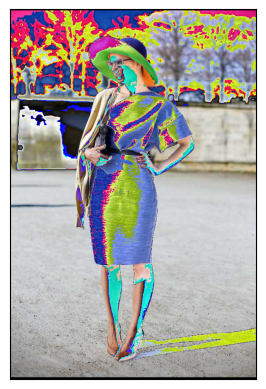

In [ ]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
model = get_model_global(num_classes=Params.class_num)  # Create an instance of your model
checkpoint = torch.load('save_model.pth', map_location=device)  # Load the checkpoint
model.load_state_dict(checkpoint)  # Load the model's state dictionary
model.to(device) # Move to appropriate device
model.eval()
if not os.path.exists('/content/img_0985.png'): uploaded = files.upload()
score_threshold = 0.5
image = Image.open('/content/img_0985.png')
image = transform_func(image)
model.eval()
output = model([image.to(device)])
overlay = draw_bounding_boxes(image, output[0]['boxes'][output[0]['scores'] > score_threshold], width=5)
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(overlay)


In [ ]:
# Before training, verify predictions on a batch
model = m_lm.model
model.eval()
with torch.no_grad():
    image_tensor = transform_func(Image.open('/content/people-clothing-segmentation/png_images/IMAGES/img_0002.png')).unsqueeze(0).to(device)
    outputs = model(image_tensor)
    print("Initial predictions:", outputs)

In [ ]:
# Remove the tiny_dataset and tiny_loader creation
!pip install --upgrade torch_xla
# Train only on the first few batches for overfitting
trainer = pl.Trainer(max_epochs=20, overfit_batches=1)  # Overfit on 3 batches

# Use the original train_dataloader with overfit_batches
trainer.fit(m_lm, train_dataloaders=m_dm.train_dataloader())

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajkumarl/people-clothing-segmentation")

print("Path to dataset files:", path)

In [ ]:
import shutil
import os

# Source and destination paths
source_path = path # '/kaggle/input/people-clothing-segmentation'
destination_path = '/content/people-clothing-segmentation'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the dataset (instead of moving)
for item in os.listdir(source_path):
    s = os.path.join(source_path, item)
    d = os.path.join(destination_path, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, symlinks=False, ignore=None)
    else:
        shutil.copy2(s, d)

print(f"Dataset copied from '{source_path}' to '{destination_path}'")

In [ ]:
import os
import re
import numpy as np
from PIL import Image

def create_image_content_dictionaries(image_dir, mask_dir, class_map):
    """
    Creates dictionaries of image content based on grayscale masks and a class map.

    Args:
        image_dir (str): Path to the directory containing images.
        mask_dir (str): Path to the directory containing masks.
        class_map (dict): Dictionary mapping grayscale values to class names.

    Returns:
        dict: A dictionary where keys are image filenames and values are dictionaries
              containing detected objects and their bounding boxes.
    """

    image_content_dicts = {}  # Dictionary to store results

    # Get lists of image and mask files
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)

    # Regular expression to extract image number from filename
    pattern = r"^img_\d{4}\.png$"  # Or adjust as needed

    # Iterate through image files
    for image_file in image_files:
        if re.match(pattern, image_file):
            image_number = image_file.split('_')[1].split('.')[0]  # Get 'xxxx' from 'img_xxxx.png'
            mask_file_name = f"seg_{image_number}.png"
        else:
            image_number = image_file.split('.')[0]  # Assuming format like 'xxxx.png'
            mask_file_name = f"{image_number}.png"

        # Check if corresponding mask file exists
        mask_path = os.path.join(mask_dir, mask_file_name)
        if os.path.exists(mask_path):
            # Load image and mask
            #image = Image.open(os.path.join(image_dir, image_file)).convert('RGB')
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)

            # Detect objects and create bounding boxes
            objects_in_image = {}  # Dictionary to store objects for this image
            unique_values = np.unique(mask_array)

            for value in unique_values:
                if value in class_map:
                    class_name = class_map[value]
                    # Get coordinates of pixels with this value
                    rows, cols = np.where(mask_array == value)
                    # Create bounding box
                    if rows.size > 0 and cols.size > 0:  # Check for non-empty mask
                        x1, y1 = cols.min(), rows.min()
                        x2, y2 = cols.max(), rows.max()
                        objects_in_image[class_name] = (x1, y1, x2, y2)
                    else:
                        print(f"Warning: Class '{class_name}' has an empty mask in image '{image_file}'.")  # Debugging

            # Store results for this image
            image_content_dicts[image_file] = objects_in_image

        else:
            print(f"Warning: Mask file not found for image '{image_file}'. Skipping this image.")

    return image_content_dicts

In [ ]:
import os
import pickle  # For saving the dictionary data

# ... (Assuming you have the create_image_content_dictionaries function defined) ...

# Get the image content dictionaries
image_dir = '/content/people-clothing-segmentation/png_images/IMAGES'
mask_dir = '/content/people-clothing-segmentation/png_masks/MASKS'
image_content_data = create_image_content_dictionaries(image_dir, mask_dir, class_map)

# Save the dictionary data to a file
output_file = '/content/image_content_data.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(image_content_data, f)

print(f"Image content data saved to: {output_file}")

In [ ]:
import pickle

# Load the saved image content data
output_file = '/content/image_content_data.pkl'
with open(output_file, 'rb') as f:
    image_content_data = pickle.load(f)

# Iterate through the first 50 images
for i, (image_file, content) in enumerate(image_content_data.items()):
    if i >= 50:  # Limit to the first 50
        break

    print(f"Image: {image_file}")
    if content:  # Check if content is not empty
        for class_name, bbox in content.items():
            print(f"  - {class_name}: {bbox}")
    else:
        print("  - No objects detected")

In [ ]:
import numpy as np
from PIL import Image
from scipy import stats

def get_mode_color_in_bbox(mask_path, bbox, class_map):
    """
    Retrieves the mode color value within a bounding box in a grayscale mask.

    Args:
        mask_path (str): Path to the grayscale mask image.
        bbox (tuple): Bounding box coordinates (x1, y1, x2, y2).
        class_map (dict): Dictionary mapping grayscale values to class names.

    Returns:
        int or None: The mode color value within the bounding box, or None if the
                     bounding box is empty or invalid.
    """

    # Load mask image as grayscale
    mask = Image.open(mask_path).convert('L')
    mask_array = np.array(mask)

    # Extract region of interest (ROI) defined by the bounding box
    x1, y1, x2, y2 = bbox
    roi = mask_array[y1:y2 + 1, x1:x2 + 1]  # Slicing to get ROI

    # Check if ROI is empty
    if roi.size == 0:
        print("Warning: Bounding box is empty. Returning None.")  # Debugging
        return None

    # Calculate mode color within ROI
    # Fix: Check if mode result is scalar and handle it
    mode_result = stats.mode(roi, axis=None)
    mode_color = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

    # Convert mode color to class name if desired
    if class_map:
        class_name = class_map.get(mode_color)  # Get class name if available
        # Handle cases where the color isn't in the class map (optional)
        if class_name is not None:
            print(f"Mode color in bounding box: {mode_color} (Class: {class_name})")
        else:
            print(f"Mode color in bounding box: {mode_color} (Not found in class map)")

    return mode_color  # Or return class_name if you prefer

In [ ]:
import pickle
import os
#from mode_color_in_bbox import get_mode_color_in_bbox  # Assuming you saved the function earlier


# Load the saved image content data
output_file = '/content/image_content_data.pkl'
with open(output_file, 'rb') as f:
    image_content_data = pickle.load(f)

mask_dir = '/content/people-clothing-segmentation/png_masks/MASKS'  # Path to mask directory

# Iterate through the first 50 images
for i, (image_file, content) in enumerate(image_content_data.items()):
    if i >= 50:
        break

    print(f"Image: {image_file}")

    # Get mask file path
    image_number = image_file.split('_')[1].split('.')[0]  # Extract image number
    mask_file_name = f"seg_{image_number}.png"  # Construct mask filename
    mask_path = os.path.join(mask_dir, mask_file_name)

    # Update content dictionary with mode color
    for class_name, bbox in content.items():
        mode_color = get_mode_color_in_bbox(mask_path, bbox, class_map)  # Get mode color
        content[class_name] = (bbox, mode_color)  # Update entry with bbox and mode color

    # Print updated content
    for class_name, (bbox, mode_color) in content.items():
        print(f"  - {class_name}: {bbox}, Mode Color: {mode_color}")

In [ ]:
import numpy as np
from PIL import Image
from scipy import stats

def get_mode_color_in_bbox(image_path, bbox):
    """
    Retrieves the mode color value within a bounding box in an image.

    Args:
        image_path (str): Path to the image.
        bbox (tuple): Bounding box coordinates (x1, y1, x2, y2).

    Returns:
        str or None: The mode color value in rgb(R, G, B) format,
                      or None if the bounding box is empty or invalid.
    """
    # ... (rest of the function remains the same)

    # Ensure mode_color is a valid RGB tuple
    if mode_result.mode.size > 0:  # Check if mode_result.mode is not empty
        mode_color = tuple(map(int, mode_result.mode[0]))  # Convert to integers and unpack
        mode_color_str = f"rgb({mode_color[0]}, {mode_color[1]}, {mode_color[2]})"  # Format as rgb(R, G, B)
    else:
        mode_color_str = None  # Handle cases where mode is empty

    return mode_color_str  # Return the formatted string

In [ ]:
import pickle
import os
import numpy as np
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load image content data
with open('/content/image_content_data.pkl', 'rb') as f:
    image_content_data = pickle.load(f)

# Color ranges (adjust as needed)
color_ranges = {
    "blue": [(0, 0, 100), (100, 100, 255)],  # Example range for blue
    # Add more color ranges here...
}

@app.route('/search', methods=['GET'])
def search():
    class_name = request.args.get('class_name')
    color_filter = request.args.get('color_filter')

    results = []
    for image_file, content in image_content_data.items():
        for detected_class, data in content.items():
            if detected_class == class_name:
                bbox, mode_color_str, *_ = data  # Get mode_color_str

                # Apply color filter if provided
                if color_filter:
                    lower_bound, upper_bound = color_ranges.get(color_filter)
                    if lower_bound and upper_bound:
                        # Extract RGB values from mode_color_str
                        rgb_values = tuple(map(int, mode_color_str[4:-1].split(',')))  # Extract numbers from rgb(R, G, B)

                        # Check if mode_color is within the color range
                        is_in_range = all(lower_bound[i] <= rgb_values[i] <= upper_bound[i] for i in range(3))
                        if not is_in_range:
                            continue  # Skip if not in color range

                results.append({"image_file": image_file, "bbox": bbox, "mode_color": mode_color_str})  # Include mode_color
                break  # Stop searching for this class in this image

    return jsonify(results)

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)

In [ ]:
!pip install Flask
import pickle
import os
import numpy as np
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load image content data
with open('/content/image_content_data.pkl', 'rb') as f:
    image_content_data = pickle.load(f)

# Color ranges (adjust as needed)
color_ranges = {
    "blue": [(0, 0, 100), (100, 100, 255)],  # Example range for blue
    # Add more color ranges here...
}

@app.route('/search', methods=['GET'])
def search():
    class_name = request.args.get('class_name')
    color_filter = request.args.get('color_filter')

    results = []
    for image_file, content in image_content_data.items():
        for detected_class, data in content.items():
            if detected_class == class_name:
                bbox, mode_color, *_ = data

                # Apply color filter if provided
                if color_filter:
                    lower_bound, upper_bound = color_ranges.get(color_filter)
                    if lower_bound and upper_bound:
                        # Check if mode_color is within the color range
                        is_in_range = all(lower_bound[i] <= int(mode_color[i]) <= upper_bound[i] for i in range(3))
                        if not is_in_range:
                            continue  # Skip if not in color range

                results.append({"image_file": image_file, "bbox": bbox})
                break  # Stop searching for this class in this image

    return jsonify(results)

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)

In [ ]:
trainer = pl.Trainer(accelerator='cuda', max_epochs=1)  # Adjust accelerator as needed
trainer.validate(m_lm, datamodule=m_dm)

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Load the saved image content data
output_file = '/content/image_content_data.pkl'
with open(output_file, 'rb') as f:
    image_content_data = pickle.load(f)

# --- Verify data structure and mode_color values ---
for i, (image_file, content) in enumerate(image_content_data.items()):
    if i >= 5:  # Limit to the first 5 images for verification
        break

    print(f"Image: {image_file}")
    for class_name, data in content.items():
        print(f"  - {class_name}: {data}")  # Print the entire data structure
        if isinstance(data, tuple) and len(data) >= 2:
            bbox, mode_color, *_ = data
            print(f"    Mode Color: {mode_color}, Type: {type(mode_color)}")

# --- Create the plot ---
fig, ax = plt.subplots()

for i, (image_file, content) in enumerate(image_content_data.items()):
    if i >= 5:
        break

    for j, (class_name, data) in enumerate(content.items()):
        if j >= 5:
            break

        if isinstance(data, tuple) and len(data) >= 2:
            bbox, mode_color, *_ = data

            if isinstance(mode_color, (tuple, list)) and len(mode_color) == 3:
                try:
                    normalized_color = tuple(int(c) / 255 for c in mode_color)
                    rect = patches.Rectangle((i, j), 1, 1, linewidth=1, edgecolor='black', facecolor=normalized_color)
                    ax.add_patch(rect)
                except (TypeError, ValueError) as e:
                    print(f"Error creating color swatch for {class_name} in {image_file}: {e}")

            text = f"{class_name}\n({image_file})"
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='white', fontsize=8)
        else:
            print(f"Warning: Unexpected data format for class '{class_name}' in image '{image_file}'. Skipping.")

ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-0.5, 5.5)
ax.set_xticks(range(5))
ax.set_xticklabels([f"Image {i+1}" for i in range(5)])
ax.set_yticks(range(5))
ax.set_yticklabels([f"Object {i+1}" for i in range(5)])
ax.set_xlabel("Images")
ax.set_ylabel("Objects")
ax.set_title("Mode Colors of Objects in Images")

# Show the plot
plt.show()

In [ ]:
import pandas as pd

def process_data_to_csv(data, csv_file_path):
  if isinstance(data, pd.DataFrame):
      data.to_csv(csv_file_path, index=False)
  elif isinstance(data, list):
      # Example handling for a list of lists
      df = pd.DataFrame(data)
      df.to_csv(csv_file_path, index=False)
  elif isinstance(data, dict):
      # Example handling for a dictionary
      df = pd.DataFrame([data])
      df.to_csv(csv_file_path, index=False)
  else:
      raise ValueError("Unsupported data type for CSV conversion.")

In [ ]:
import pickle

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data
def convert_pickle_to_csv(pickle_file_path, csv_file_path):
    data = load_pickle(pickle_file_path)
    process_data_to_csv(data, csv_file_path)

In [ ]:
pickle_file = "image_content_data.pkl"
csv_file = "output.csv"
convert_pickle_to_csv(pickle_file, csv_file)

In [ ]:

save_model(m_lm.model, '/content/save_model.pth')  # Assuming m_lm.model is the actual model object

In [ ]:
model = get_model_global(num_classes=Params.class_num)  # Create an instance of your model
checkpoint = torch.load('save_model.pth', map_location=device)  # Load the checkpoint

# Load the state dictionary directly without the 'model_state_dict' key
model.load_state_dict(checkpoint)  # Load the model's state dictionary

model.to(device) # Move to appropriate device
model.eval()  # Set the model to evaluation mode
image_raw = Image.open('/content/bbb_files_png/png_images/TEST_IMAGES/img_0986.png').convert('RGB')
image = transform_func(image_raw)
image = image.unsqueeze(0).to(device)
with torch.no_grad():  # Disable gradient calculations during inference
  predictions = model(image)
print(predictions)



In [ ]:
model = get_model_global(num_classes=Params.class_num)  # Create an instance of your model
checkpoint = torch.load('save_model.pth', map_location=device)  # Load the checkpoint
model.load_state_dict(checkpoint)  # Load the model's state dictionary
model.to(device)  # Move to appropriate device
model.eval()  # Set the model to evaluation mode

# Get a batch of data from the test dataloader
val_dataloader = m_dm.val_dataloader()  # Assuming you have m_dm defined
images, targets = next(iter(val_dataloader))  # Get the first batch

# Move images to the appropriate device
images = images.to(device)

with torch.no_grad():  # Disable gradient calculations during inference
    predictions = model(images)

# Loop through predictions for each image in the batch
for i, prediction in enumerate(predictions):
    print(f"Predictions for image {i}:")
    for key, value in prediction.items():
        print(f"  {key}:")
        if isinstance(value, torch.Tensor):
            # If it's a tensor, print its values
            print(f"    {value}")
            print(f"    Shape: {value.shape}")
            print(f"    dtype: {value.dtype}")
        else:
            # If it's not a tensor, just print its value
            print(f"    {value}")
    print("-" * 20)  # Separator between images

In [ ]:
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import box_iou
class Mask_LM(pl.LightningModule):
    def __init__(
            self,
            rand_seed=Params.seed,
            img_dim_x=Params.img_dim_x,
            img_dim_y=Params.img_dim_y,
            num_classes=Params.class_num,
            album_bbox_form=Params.album_bbox_form,
            class_map=Params.class_map,
            batch_size=Params.batch_size,
            num_workers=Params.num_workers,
            transform_func=transform_func,
            learning_rate=Params.learning_rate,
            num_epochs=Params.num_epochs

    ):
        # ... (your existing code) ...
        self.freeze_epochs = 2  # Number of epochs to freeze layers
        self.unfreeze_epochs = 2  # Number of epochs after which to unfreeze more layers
        self.current_epoch = 0

    def on_train_epoch_start(self):
        """Called at the beginning of each training epoch."""
        self.current_epoch += 1

        # Freeze or unfreeze layers based on the current epoch
        if self.current_epoch == 1:
            self.freeze_backbone()
        elif self.current_epoch % self.unfreeze_epochs == 0:  # Unfreeze more layers every 'unfreeze_epochs'
            self.unfreeze_more_layers()

    def freeze_backbone(self):
        """Freeze all layers except the final classification layers."""
        for param in self.model.parameters():
            param.requires_grad = False  # Freeze all parameters

        # Unfreeze the final classification layers (you may need to adjust this based on your model's architecture)
        for param in self.model.roi_heads.box_predictor.parameters():
            param.requires_grad = True
        for param in self.model.roi_heads.mask_predictor.parameters():
            param.requires_grad = True

    def unfreeze_more_layers(self):
        """Unfreeze a specific set of layers."""
        # Adjust this to unfreeze the desired layers progressively
        # For example, unfreeze a block of layers in the backbone
        for param in self.model.backbone.layer3.parameters():
            param.requires_grad = True
        for param in self.model.backbone.layer4.parameters():
            param.requires_grad = True

    # ... (your other methods) ...

In [ ]:
from memory_profiler import memory_usage
import pytorch_lightning as pl
import logging

class MemoryMonitor(pl.Callback):
    def __init__(self, log_interval=100):
        super().__init__()
        self.log_interval = log_interval

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if (batch_idx + 1) % self.log_interval == 0:
            mem_usage = memory_usage(proc=-1, max_usage=True)[0]  # Get memory usage in MiB
            logging.info(f"Memory usage at batch {batch_idx + 1}: {mem_usage:.2f} MiB")

In [ ]:
del model

In [ ]:
# ... your imports and model loading code ...

# Print the model architecture (including the mask head)
print(Mask_LM().model)

# Access and print the mask head specifically
print(Mask_LM().model.roi_heads.mask_predictor)

# Access specific layers within the mask head
# Example: Print the architecture of the 'conv5_mask' layer
print(Mask_LM().model.roi_heads.mask_predictor.conv5_mask)

In [ ]:
print(model.roi_heads.mask_predictor)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/version_0/
%ls lightning_logs/version_0/

In [ ]:
from collections import defaultdict
uniqColors = set()

for root, dirs, files in os.walk("/content/png_masks"):
    for file in files:
        if file.endswith(('png')):
            try:
                path = os.path.join(root, file)
                with Image.open(path) as imgge:

                    colors = imgge.getdata()
                    uniqColors.update(set(colors))

            except Exception as e:
                print(f"Error {e}")
print(uniqColors)


In [ ]:
print(len(uniqColors))
gs_values = np.array(list(uniqColors)).reshape(1, -1)
plt.imshow(gs_values, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [ ]:
image = Image.open('/content/png_masks/MASKS/seg_0989.png')
image = transform_func(image)
image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))
image = (image * 0.5) + 0.5
plt.imshow(image)

#Make csv of classes in images and mode colors

In [ ]:
def get_mode_color(boxes, img, labels, image_path):
  i: int = 0
  colors_n_labels = {}
  for box in boxes:
    xmin, ymin, xmax, ymax = boxes
    pixels = img[:, ymin:ymax, xmin:xmax]
    mode_color = pixels.mode()
    colors_n_labels{
        'label': labels[i],
        'color': mode_color,
        'image path': image_path
    }
    i += 1
  return colors_n_labels


In [ ]:
idx: int = 0
for root, dirs, files in os.walk('/content/bbb_files_png/'):
  for file in files:
    if file.endswith(('png')):
      try:
        path = os.path.join(root, file)

  image_files = os.listdir(Params.image_dir)
  image_path = os.path.join(Params.image_dir, image_files[idx])
  image_number = Params.image_files[idx].split('_')[1].split('.')[0]
  mask_file_name = f"seg_{image_number}.png"

  mask_path = os.path.join(Params.mask_dir, mask_file_name)
  if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Could not find mask file: {mask_path}")
  image = Image.open(image_path).convert('RGB')
  mask = Image.open(mask_path).convert('L')

  mask = np.array(mask)
  labels = []
  masks = []
  class_num = len(Params.class_map)
  for i in range(class_num):
    mask_of_class = mask == i #some kinda magic that makes a copy of the mask with 1s where the class number is
    if np.any(mask_of_class):
      labeled_mask, things_num = ndimage.label(mask_of_class)
      for j in range(1, things_num + 1):
          object_mask = (labeled_mask == j).astype(np.uint8) # ??? dim correct???
          masks.append(torch.tensor(object_mask, dtype=torch.int64))
          labels.append(Params.class_map.get(i))
  del mask_of_class, labeled_mask

  #masks[i, :, :] = mask == i
  #self.class_map.get(i, "background"
  #.expand(Params.batch_size, -1, -1)
  boxes = []
  for mask in masks:
    boxes.append(ops.masks_to_boxes(mask.unsqueeze(0)))
  boxes = torch.cat(boxes, dim=0)
  transform = transforms.ToTensor()
  get_mode_color(boxes, transform(image), labels, image_path)